# Preprocesado e ingeniería de características

En esta sesión de trabajo con Jupyter aplicaremos los conceptos presentados en el módulo sobre preprocesado e ingeniería de características a los conjuntos de datos Titanic e Iris.

## Manipulación de características

En los siguientes ejercicios vamos a utilizar el conjunto de datos [Titanic](http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic.html) para realizar distintos tipos de modificaciones en los datos: rellenado de valores ausentes y modificación de características categóricas mediante correspondencia numérica, codificación *one-hot* y escalado. El conjunto de datos Titanic contiene información sobre 1309 pasajeros del Titanic el día del naufragio, indicando 14 características como su nombre, sexo, edad, número de ticket, tarifa, puerto de embarque, clase en la que viajaba y si sobrevivió al desastre.

El conjunto de datos está en formato CSV así que utlizaremos la librería Pandas para leerlo.

In [1]:
import pandas as pd

Aunque podemos coger el conjunto de datos de la página web de la Universidad Vanderbilt, vamos a usar una versión ligeramente modificada por A. Müller para su libro "Introducción to Machine Learning with Python".

In [2]:
titanic_url = ('https://raw.githubusercontent.com/amueller/'
               'scipy-2017-sklearn/091d371/notebooks/datasets/titanic3.csv')
df = pd.read_csv(titanic_url)

Para tener una idea de cómo es este conjunto de datos podemos visualizar los 5 primeros registros.

In [3]:
df[0:5]

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


Para este ejercicio utilizaremos las características clase (pclass), sexo (sex), edad (age), tarifa (fare) y puerto de embarque (embarked). Clase es una característica numérica que puede tomar tres valores, 1, 2 o 3, correspondiendo con la clase en la que se encontraba el pasajero. Edad y tarifa son características numéricas continuas. Sexo y puerto de embarque son características de tipo categórico.

In [4]:
data = df[['pclass','sex','age','fare','embarked']]

#### Valores ausentes en los datos

Primero vamos a analizar los datos para comprobar si existen valores ausentes y cuántos hay. Para esto usamos el método 
`isnull()` de los *dataframe* de Pandas, que crea un índice de los valores nulos; y a continuación contamos cuantos valores nulos hay para cada característica con el método `sum()`.

In [5]:
data.isnull().sum()

pclass        0
sex           0
age         263
fare          1
embarked      2
dtype: int64

Como podemos ver hay una gran cantidad de valores ausentes para la característica edad y uno o dos para las características tarifa y puerto de embarque.

La primera forma de tratar con valores ausentes consiste en eliminarlos. Esto es fácil de hacer usando la librería Pandas. Simplemente hay que usar el método `dropna()` de los *dataframe* para conseguirlo.

In [6]:
data.dropna()

,pclass,sex,age,fare,embarked
0,1,female,29.0000,211.3375,S
1,1,male,0.9167,151.5500,S
2,1,female,2.0000,151.5500,S
3,1,male,30.0000,151.5500,S
4,1,female,25.0000,151.5500,S
...,...,...,...,...,...
1301,3,male,45.5000,7.2250,C
1304,3,female,14.5000,14.4542,C
1306,3,male,26.5000,7.2250,C
1307,3,male,27.0000,7.2250,C


A continuación vamos a ver medidas menos drásticas para tratar con los valores ausentes, pero antes vamos a crear un índice de los valores ausentes de la característica edad, para ver el efecto de los cambios que vamos a realizar.

In [7]:
missing = data['age'].isnull()

data[missing][0:5]

,pclass,sex,age,fare,embarked
15,1,male,NaN,25.9250,S
37,1,male,NaN,26.5500,S
40,1,male,NaN,39.6000,C
46,1,male,NaN,31.0000,S
59,1,female,NaN,27.7208,C


Vamos a rellenar los valores ausentes de la característica edad con la media de todos los datos disponibles. El valor de la media se puede obtener con el método `mean()` de los *dataframe*.

In [8]:
data['age'].mean()

29.8811345124283

Para rellenar los campos vacíos de una característica vamos a utilizar la clase `SimpleImputer` de la librería `impute` de *Scikit-learn*. Esta clase nos permite rellenar los campos vacíos de un conjunto de datos con distintas estrategias, como la media, la mediana o la moda.

In [9]:
from sklearn.impute import SimpleImputer

El inconveniente es que la clase `SimpleImputer` actúa sobre todo el conjunto de datos, usando la misma estrategia para rellenar todos los huecos vacíos de todas las características. Si usamos esta clase con el objetivo de rellenar los campos vacíos de la característica edad con la media, se producirá un error al tratar de rellenar los campos vacíos de características categóricas. La única estrategia válida para cualquier característica, independientemente de si es categórica o numérica, es la moda.

In [10]:
si = SimpleImputer(strategy='mean')

#si.fit(data)

La versión 0.20.2 de *Scikit-learn* incorpora la clase `ColumnTransformer` con el objetivo de hacer transformaciones en un conjunto de datos especificando las columnas sobre las que queremos actuar. Se encuentra en la librería `compose`.

In [11]:
from sklearn.compose import ColumnTransformer

En el constructor de la clase `ColumnTransformer` hay que proporcionar una lista de ternas formadas por un nombre único asociado a la transformación para un conjunto de columnas, la transformación que queremos realizar (en este caso rellenar los campos vacíos con la media) y las columnas sobre las que queremos actuar (en este caso la característica edad). Podemos indicar varias columnas y la transformación se llevará a cabo sobre todas ellas de forma independiente.

In [12]:
ct = ColumnTransformer([("media",SimpleImputer(strategy='mean'),['age'])])

Entrenamos esta instancia de la clase `ColumnTransformer` con los datos y podemos ver el resultado sobre los ejemplos que contenían valores vacíos para la característica edad.

In [13]:
X = ct.fit_transform(data)

X[missing][0:5]

array([[29.88113451],
       [29.88113451],
       [29.88113451],
       [29.88113451],
       [29.88113451]])

Como podemos observar, se ha producido la transformación, pero hemos perdido el resto de columnas de nuestro conjunto de datos. Esto es porque la clase `ColumnTransformer` actúa sobre las características que se indican, eliminando todas las demás. Si queremos modificar este comportamiento, podemos hacerlo usando el parámetro `remainder`, que sirve para especificar qué hacer con el resto de las características, con el valor `passthrough`, que indica que se deben dejar sin modificar.

In [14]:
ct = ColumnTransformer([("media",SimpleImputer(strategy='mean'),['age'])],
                        remainder='passthrough')

X = ct.fit_transform(data)

X[missing][0:5]

array([[29.8811345124283, 1, 'male', 25.925, 'S'],
       [29.8811345124283, 1, 'male', 26.55, 'S'],
       [29.8811345124283, 1, 'male', 39.6, 'C'],
       [29.8811345124283, 1, 'male', 31.0, 'S'],
       [29.8811345124283, 1, 'female', 27.7208, 'C']], dtype=object)

Otra cosa que observamos ahora es que se ha alterado el orden de las características. Esto se debe a que la clase `ColumnTransformer` deja las características en el orden en que se indican en la lista de transformaciones. Si queremos mantener el orden original, deberíamos indicar una transformación nula para el resto de características distintas de la edad, en el orden que queramos mantener. La transformación nula se indica usando el valor `'passthrough'` como segundo campo de las ternas que indican cómo actuar sobre las columnas.

In [15]:
ct = ColumnTransformer([("original1",'passthrough',['pclass','sex']),
                        ("media",SimpleImputer(strategy='mean'),['age']),
                        ("original2",'passthrough',['fare','embarked'])])

X = ct.fit_transform(data)

In [16]:
print(ct.transform(data)[missing])

[[1 'male' 29.8811345124283 25.925 'S']
 [1 'male' 29.8811345124283 26.55 'S']
 [1 'male' 29.8811345124283 39.6 'C']
 ...
 [3 'male' 29.8811345124283 7.225 'C']
 [3 'male' 29.8811345124283 14.4583 'C']
 [3 'female' 29.8811345124283 14.4542 'C']]


Vamos ahora a rellenar valores ausentes usando otro criterio, en concreto la mediana para la característica tarifa. La mediana de un conjunto de datos se puede obtener con el método `median()` de los *dataframe*.

In [17]:
data['fare'].median()

14.4542

Hacer esta modificación es tan simple como indicarla en una instancia de la clase `ColumnTransformer` sobre el dato correspondiente. En este caso ampliamos la instancia anterior para hacer esta segunda modificación.

In [18]:
ct = ColumnTransformer([("original1",'passthrough',['pclass','sex']),
                         ("si1",SimpleImputer(strategy='mean'),['age']),
                         ("si2",SimpleImputer(strategy='median'),['fare']),
                         ("original2",'passthrough',['embarked'])])

X = ct.fit_transform(data)

Finalmente vamos a rellenar los valores ausentes de la característica puerto de embarque con la moda. La moda de un conjunto de datos se puede obtener con el método `mode()` de los *dataframe*. En el resultado se muestran todos los valores que tiene un máximo de frecuencia de aparición en el conjunto de datos.

In [19]:
data['embarked'].mode()

0    S
dtype: object

Finalmente incluimos esta transformación para la característica puerto de embarque en la instancia de la clase `ColumnTransformer`. Una vez hecho esto, entrenamos la clase con nuestro conjunto de datos y creamos una versión modificada para usarla en el resto de esta hoja de trabajo.

In [20]:
ct = ColumnTransformer([("original1",'passthrough',['pclass','sex']),
                        ("si1",SimpleImputer(strategy='mean'),['age']),
                        ("si2",SimpleImputer(strategy='median'),['fare']),
                        ("si3",SimpleImputer(strategy='most_frequent'),['embarked'])])

X = ct.fit_transform(data)

#### Características categóricas

Vamos a tratar ahora con transformaciones de características categóricas: correspondencia numérica y codificación *one-hot*. Aunque más adelante usaremos de nuevo la clase `ColumnTransformer` para integrar otras transformaciones de los datos, esto no es posible hacerlo para la correspondencia numérica, que tendremos que hacer sobre cada columna de forma aislada.

Podemos ver el conjunto de valores que toma una característica con el método `unique()` de los *dataframe*. En este caso podemos comprobar que la característica sexo toma unicamente dos valores.

In [21]:
df['sex'].unique()

array(['female', 'male'], dtype=object)

En *Scikit-learn* podemos hacer una correspondencia numérica con la clase `LabelEncoder` de la librería `preprocessing`. Al entrenar una instancia de esta clase con un conjunto de datos, se identifican los valores o clases que existen y, posteriormente, se pueden reemplazar por valores numéricos.

In [22]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

le.fit(X[:,1])

LabelEncoder()

El conjunto de clases identificadas se almacena en el campo `classes_`

In [23]:
print(le.classes_)

['female' 'male']


Ahora podemos transformar los datos originales

In [24]:
X[:,1] = le.transform(X[:,1])

print(X[0:5])

[[1 0 29.0 211.3375 'S']
 [1 1 0.9167 151.55 'S']
 [1 0 2.0 151.55 'S']
 [1 1 30.0 151.55 'S']
 [1 0 25.0 151.55 'S']]


La codificación *one-hot* se consigue utilizando la clase `OneHotEncoder` de la librería `preprocessing`. En este caso podemos integrar esta transformación como un modificador de una instancia de la clase `ColumnTransformer` sobre las columnas que nos interesen. Vamos a hacerlo primero sobre la característica sexo.

In [25]:
from sklearn.preprocessing import OneHotEncoder

ct = ColumnTransformer([("original1",'passthrough',['pclass']),
                        ("ohe",OneHotEncoder(),['sex']),
                        ("si1",SimpleImputer(strategy='mean'),['age']),
                        ("si2",SimpleImputer(strategy='median'),['fare']),
                        ("si3",SimpleImputer(strategy='most_frequent'),['embarked'])])

X = ct.fit_transform(data)

In [26]:
print(X[0:5])

[[1 1.0 0.0 29.0 211.3375 'S']
 [1 0.0 1.0 0.9167 151.55 'S']
 [1 1.0 0.0 2.0 151.55 'S']
 [1 0.0 1.0 30.0 151.55 'S']
 [1 1.0 0.0 25.0 151.55 'S']]


Hacer lo mismo sobre la característica puerto de embarque no es tan simple, puesto que ya habíamos indicado una modificación para esta característica. Para conseguir hacer una segunda modificación sobre una característica vamos a usar la clase `Pipeline` de la librería `pipeline`. Con esta clase podemos indicar una secuencia de transformaciones a realizar sobre un conjunto de datos. Estas transformaciones se realizan de forma secuencial sobre los datos e incluso se podría indicar como paso final un modelo de decisión. En nuestro caso, creamos una instancia de la clase `Pipeline` para rellenar primero los valores ausentes con el valor más frecuente (la moda) y después hacemos una codificación *one-hot*.

A continuación, usamos la instancia de la clase `Pipeline` que acabamos de crear como transformador asociado a la característica puerto de embarque en una instancia de la clase `ColumnTransformer`.

In [27]:
from sklearn.pipeline import Pipeline

impohe = Pipeline([('si3', SimpleImputer(strategy='most_frequent')),
                   ('onehot', OneHotEncoder())])

ct = ColumnTransformer([("original1",'passthrough',['pclass']),
                        ("ohe",OneHotEncoder(),['sex']),
                        ("si1",SimpleImputer(strategy='mean'),['age']),
                        ("si2",SimpleImputer(strategy='median'),['fare']),
                        ("impohe",impohe,['embarked'])])

X = ct.fit_transform(data)

In [28]:
X[0:5]

array([[  1.    ,   1.    ,   0.    ,  29.    , 211.3375,   0.    ,
          0.    ,   1.    ],
       [  1.    ,   0.    ,   1.    ,   0.9167, 151.55  ,   0.    ,
          0.    ,   1.    ],
       [  1.    ,   1.    ,   0.    ,   2.    , 151.55  ,   0.    ,
          0.    ,   1.    ],
       [  1.    ,   0.    ,   1.    ,  30.    , 151.55  ,   0.    ,
          0.    ,   1.    ],
       [  1.    ,   1.    ,   0.    ,  25.    , 151.55  ,   0.    ,
          0.    ,   1.    ]])

#### Escalado

El último tipo de transformación que vamos a ver en este ejemplo es el escalado, que puede ser de dos tipos, normalización o estandarización. 

La normalización se consigue con la clase `MinMaxScaler` de la librería `preprocessing`. En nuestro ejemplo, usamos normalización para escalar los datos de la edad. Para conseguir hacer esto después de haber rellenado los valores ausentes de esta característica con la media, usamos una nueva instancia de la clase `Pipeline` indicando las dos transformaciones que queremos realizar y usamos esta instancia como transformador para la característica edad en una instancia de la clase `ColumnTransformer`.

In [29]:
from sklearn.preprocessing import MinMaxScaler

pip1 = Pipeline([('si1', SimpleImputer(strategy='mean')),
                 ('scaler1',MinMaxScaler())])

ct = ColumnTransformer([("original1",'passthrough',['pclass']),
                        ("ohe1",OneHotEncoder(),['sex']),
                        ("pip1",pip1,['age']),
                        ("si2",SimpleImputer(strategy='median'),['fare']),
                        ("impohe",impohe,['embarked'])])

X = ct.fit_transform(data)

La estandarización se consigue con la clase `StandardScaler` de la librería `preprocessing`. En nuestro ejemplo, usamos estandarización para escalar los datos de la tarifa. Para conseguir hacer esto después de haber rellenado los valores ausentes de esta característica con la mediana, usamos una nueva instancia de la clase `Pipeline` indicando las dos transformaciones que queremos realizar y usamos esta instancia como transformador para la característica tarifa en una instancia de la clase `ColumnTransformer`.

In [30]:
from sklearn.preprocessing import StandardScaler

pip2 = Pipeline([('si2', SimpleImputer(strategy='median')),
                 ('scaler2',StandardScaler())])

ct = ColumnTransformer([("original1",'passthrough',['pclass']),
                        ("ohe1",OneHotEncoder(),['sex']),
                        ("pip1",pip1,['age']),
                        ("pip2",pip2,['fare']),
                        ("impohe",impohe,['embarked'])])

X = ct.fit_transform(data)

Podemos ver el resultado final comparándolo los datos originales

In [31]:
print("Datos originales: ")
print(data[0:5])

print("Datos transformados: ")
print(X[0:5])

Datos originales: 
   pclass     sex      age      fare embarked
0       1  female  29.0000  211.3375        S
1       1    male   0.9167  151.5500        S
2       1  female   2.0000  151.5500        S
3       1    male  30.0000  151.5500        S
4       1  female  25.0000  151.5500        S
Datos transformados: 
[[1.         1.         0.         0.36116884 3.44258413 0.
  0.         1.        ]
 [1.         0.         1.         0.00939458 2.2866387  0.
  0.         1.        ]
 [1.         1.         0.         0.0229641  2.2866387  0.
  0.         1.        ]
 [1.         0.         1.         0.37369494 2.2866387  0.
  0.         1.        ]
 [1.         1.         0.         0.31106443 2.2866387  0.
  0.         1.        ]]


## Reducción de la dimensionalidad

En los siguientes ejercicios vamos a utilizar de nuevo el conjunto de datos [Iris](https://es.wikipedia.org/wiki/Iris_flor_conjunto_de_datos) que contiene información de tres especies de la flor Iris: Iris setosa, Iris virginica e Iris versicolor. Recordemos que en este conjunto de datos hay información de 150 muestras de flores, 50 de cada tipo, sobre el largo y el ancho del pétalo y el sépalo, medidos en centímetros. El objetivo es aplicar distintas técnicas de reducción de dimensionalidad a este conjunto de datos.

Cargamos el conjunto de datos Iris incluido en Scikit-learn, usando la función [`load_iris()`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html) de la biblioteca `sklearn.datasets`

In [32]:
from sklearn.datasets import load_iris

iris = load_iris()

Lo primero que vamos a hacer es escalar todos los datos usando la clase `StandardScaler` para conseguir un estandarizado.

In [33]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(iris.data)
iris.data = scaler.transform(iris.data)

Cambiamos el array de nombres de las características, ya que ahora no son valores medidos en centímetros.

In [34]:
iris.feature_names = ['longitud de sépalo','anchura de sépalo',
                      'longitud de pétalo','anchura de pétalo']

Almacenamos los campos que resultan de interés para este ejercicio en variables distintas.

In [35]:
X_data, y_data, X_names, y_names = \
    iris.data, iris.target, iris.feature_names, iris.target_names

Vamos a recordar cómo se distribuían estos datos y para ello los visualizaremos usando la librería `matplotlib`. Para esto, consideramos un par de características y presentamos en un gráfico 2D un conjunto de puntos que representan cada uno de los ejemplos del conjunto de datos. Para diferenciar los valores de clasificación usamos distintas formas y colores para cada uno de ellos: cuadrados rojos para el primer valor de clasificación (Iris setosa), círculos verdes para el segundo valor de clasificación (Iris versicolor) y rombos azules para el tercer valor de clasificación (Iris virgínica).

Cargamos la biblioteca [`pyplot`](https://matplotlib.org/api/pyplot_api.html) de la librería `matplotlib` con el nombre `plt`:

In [36]:
from matplotlib import pyplot as plt

El proceso para dibujar los datos consiste en limpiar el lienzo (`plt.clf()`) y para cada terna formada por el valor de clasificación (`range(len(clases))`), la forma (`"soD"`) y el color (`"rgb"`) deseados, recoger los valores de las características a representar (`c1` y `c2`) de todos los datos con el valor de clasificación considerado. Estos puntos se representan con el método (`plt.scatter`) con la forma y el color fijados. Finalmente etiquetamos los ejes horizontal y vertical con los nombres de las características representadas.

Este proceso se puede definir como el efecto de una función:

In [37]:
def representacion_grafica(datos,caracteristicas,objetivo,clases,c1,c2):
    for tipo,marca,color in zip(range(len(clases)),"soD","rgb"):
        plt.scatter(datos[objetivo == tipo,c1],
                    datos[objetivo == tipo,c2],marker=marca,c=color)
    plt.xlabel(caracteristicas[c1])
    plt.ylabel(caracteristicas[c2])

Ahora utilizamos esta función para representar gráficamente la distribución de los datos con respecto a cada pareja de características. Eso se consigue dividiendo el lienzo en seis trozos, en 2 filas y 3 columnas con las correspondientes llamadas al método `plt.subplot`:

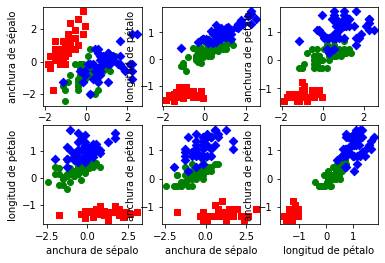

In [38]:
def representacion_conjunta(X_data,X_names,y_data,y_names):
    plt.clf()
    plt.rcParams["figure.figsize"] = [18,12]
    plt.subplot(231)
    representacion_grafica(X_data,X_names,y_data,y_names,0,1)
    plt.subplot(232)
    representacion_grafica(X_data,X_names,y_data,y_names,0,2)
    plt.subplot(233)
    representacion_grafica(X_data,X_names,y_data,y_names,0,3)
    plt.subplot(234)
    representacion_grafica(X_data,X_names,y_data,y_names,1,2)
    plt.subplot(235)
    representacion_grafica(X_data,X_names,y_data,y_names,1,3)
    plt.subplot(236)
    representacion_grafica(X_data,X_names,y_data,y_names,2,3)
    plt.subplots_adjust(wspace=0.2,hspace=0.2)
    plt.show()

representacion_conjunta(X_data,X_names,y_data,y_names)

Finalmente vamos a ver cómo se comporta un modelo de decisión cualquiera para este conjunto de datos, para tener una referencia de su rendimiento. En este caso usamos un modelo de clasificación basado en vectores soporte.

In [39]:
from sklearn.svm import LinearSVC

modelo0 = LinearSVC().fit(X_data,y_data)

modelo0.score(X_data,y_data)

0.9466666666666667

### Eliminación recursiva de características

La eliminación recursiva de características es una técnica de selección de características que consiste en construir modelos de decisión con el conjunto de datos original al que se ha quitado una característica, para cada una de las características disponibles. De estos modelos se escoge el que tenga mejor rendimiento, y se continúa de la misma forma con las características restantes. El proceso termina cuando se ha llegado a un número de características objetivo o mientras que se obtengan modelos que mejoren el rendimiento.

Vamos a hacerlo con el conjunto de datos Iris. Para esto vamos a considerar cuatro situaciones distintas, cada una de ellas como resultado de eliminar una característica del conjunto de datos original. Entrenamos un modelo de clasificación basado en vectores soporte para cada una de los conjuntos de datos resultantes y evaluamos su rendimiento.

In [40]:
X1A_data = [[x[1],x[2],x[3]] for x in X_data]

modelo1A = LinearSVC().fit(X1A_data, y_data)

modelo1A.score(X1A_data,y_data)

0.9533333333333334

In [41]:
X1B_data = [[x[0],x[2],x[3]] for x in X_data]

modelo1B = LinearSVC().fit(X1B_data, y_data)

modelo1B.score(X1B_data,y_data)

0.9666666666666667

In [42]:
X1C_data = [[x[0],x[1],x[3]] for x in X_data]

modelo1C = LinearSVC().fit(X1C_data, y_data)

modelo1C.score(X1C_data,y_data)

0.9466666666666667

In [43]:
X1D_data = [[x[0],x[1],x[2]] for x in X_data]

modelo1D = LinearSVC().fit(X1D_data, y_data)

modelo1D.score(X1D_data,y_data)

0.9133333333333333

Podemos observar que el mejor resultado se obtiene eliminando la segunda característica. Repetimos el proceso para el conjunto de datos en el que se ha eliminado esta característica, buscando una segunda simplificación.

In [44]:
X1A1_data = [[x[2],x[3]] for x in X_data]

modelo1A1 = LinearSVC().fit(X1A1_data, y_data)

modelo1A1.score(X1A1_data,y_data)

0.9533333333333334

In [45]:
X1A2_data = [[x[0],x[3]] for x in X_data]

modelo1A2 = LinearSVC().fit(X1A2_data, y_data)

modelo1A2.score(X1A2_data,y_data)

0.9466666666666667

In [46]:
X1A3_data = [[x[0],x[2]] for x in X_data]

modelo1A3 = LinearSVC().fit(X1A3_data, y_data)

modelo1A3.score(X1A3_data,y_data)

0.9533333333333334

Una vez eliminada la segunda característica, la mejor opción consiste en eliminar la primera. Si el objetivo fuese reducir el conjunto de características mientras haya mejoras en el rendimiento, entonces nos quedaríamos con las características primera, tercera y cuarta. Si el objetivo fuese reducir el conjunto de características a la mitad, entonces nos quedaríamos con las características tercera y cuarta.

*Scikit-learn* implementa una reducción recursiva de las características, eliminando en cada paso la peor caracterísica, según el grado que establezca un modelo de decisión. Esto se consigue con la clase `RFE` de la librería `feature_selection`, indicando el modelo a usar para escoger la mejor característica en cada paso como argumento en el constructor.

In [47]:
from sklearn.feature_selection import RFE

modelo1 = LinearSVC()

selector = RFE(modelo1,n_features_to_select=1,step=1)

selector.fit(X_data,y_data)

RFE(estimator=LinearSVC(), n_features_to_select=1)

En el campo `support_` se almacena un índice de las características que se obtienen como mejores. Al igual que lo ocurrido con nuestro ejemplo, se llega a la conclusión de que las mejores características son las relacionadas con el pétalo de la flor (las dos últimas).

In [48]:
selector.support_

array([False, False,  True, False])

In [49]:
selector.ranking_

array([4, 3, 1, 2])

### Selección de características basada en modelos

*Scikit-learn* también implementa la selección de características basada en modelos. Se trata de la clase `SelectFromModel` de la librería `feature_selection`.

In [50]:
from sklearn.feature_selection import SelectFromModel

Podemos seleccionar las mejores características a partir de un modelo Random Forest con una cantidad adecuada de estimadores.

In [51]:
from sklearn.ensemble import RandomForestClassifier

select1 = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42))

select1.fit(X_data,y_data)

SelectFromModel(estimator=RandomForestClassifier(random_state=42))

Con el método `get_support()` podemos obtener un índice de las mejores características encontradas.

In [52]:
select1.get_support()

array([False, False,  True,  True])

También podemos seleccionar las mejores características a partir de un modelo lineal con regularización L1.

In [53]:
from sklearn.svm import LinearSVC

select2 = SelectFromModel(LinearSVC(C=0.01, penalty="l1", dual=False))

select2.fit(X_data,y_data)

SelectFromModel(estimator=LinearSVC(C=0.01, dual=False, penalty='l1'))

En este caso, el modelo detecta que las mejores características son las tres últimas, pero el resultado cambia con valores diferentes del parámetro `C`

In [54]:
select2.get_support()

array([False,  True,  True,  True])

### Análisis de componentes principales

Para terminar, vamos a ver como realizar un análisis de componentes principales en *Scikit-learn*. Esto se consigue con la clase `PCA` de la librería `decomposition`.

In [55]:
from sklearn.decomposition import PCA

El número de componentes que queremos dejar en el resultado se puede indicar como valor del parámetro `n_components`. En este caso hemos dejado el valor 4 para ver la importancia relativa que tiene cada una de las componentes obtenidas.

In [56]:
pca = PCA(n_components=4)

pca.fit(X_data)

X_pca = pca.transform(X_data)

Los autovalores asociados a las componentes principales, es decir, el grado de importancia de estas componentes, se almacenan en el campo `explained_variance_`

In [57]:
pca.explained_variance_

array([2.93808505, 0.9201649 , 0.14774182, 0.02085386])

Como podemos observar la última componente tiene muy poca importancia comparada con las otras.

Las componentes principales, es decir, los autovectores de la matriz de covarianzas, se almacenan en el campo `components_`

In [58]:
pca.components_

array([[ 0.52106591, -0.26934744,  0.5804131 ,  0.56485654],
       [ 0.37741762,  0.92329566,  0.02449161,  0.06694199],
       [-0.71956635,  0.24438178,  0.14212637,  0.63427274],
       [-0.26128628,  0.12350962,  0.80144925, -0.52359713]])

Si hacemos una representación conjunta de las cuatro componentes podemos ver el grado de correlacion entre ellas.

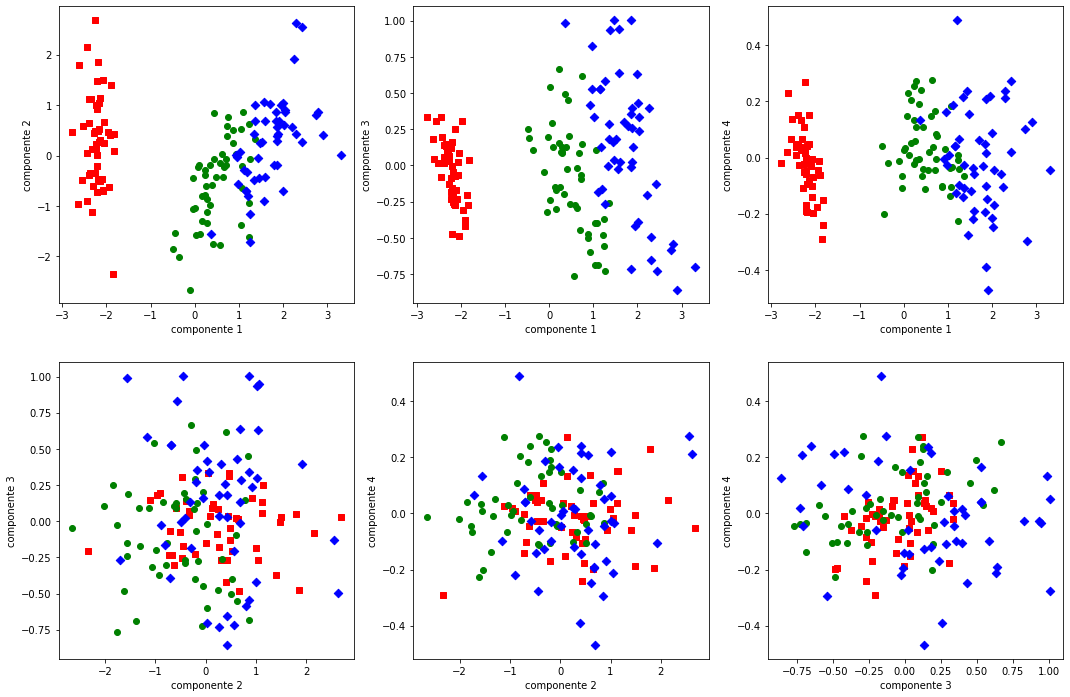

In [59]:
representacion_conjunta(X_pca,['componente 1','componente 2','componente 3','componente 4'],
                        y_data,y_names)

Dado que parece que la última componente es prescindible, podemos quedarnos con las tres primeras y modificar el conjunto de datos original para entrenar un modelo de decisión.

In [60]:
pca = PCA(n_components=3)

X_pca = pca.fit_transform(X_data)

modeloPCA = LinearSVC().fit(X_pca, y_data)

modeloPCA.score(X_pca,y_data)

0.9466666666666667